In [139]:
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal

In [140]:
from thejoker import JokerParams, TheJoker, RVData
from thejoker.sampler.io import save_prior_samples
from thejoker.plot import plot_rv_curves
from astropy.time import Time
import h5py

In [218]:
P_lim = [1e0, 1e5]
nsamples = 16384  # number of samples of the nonlinear parameter

Vdiag = np.array([1e2, 1e2]) ** 2
V = np.diag(Vdiag)

pars = JokerParams(P_min=P_lim[0]*u.day, P_max=P_lim[1]*u.day, 
                   linear_par_Vinv=np.diag(1/Vdiag))
joker = TheJoker(pars, random_state=np.random.RandomState(42))

In [219]:
prior_samples = joker.sample_prior(size=nsamples)
prior_samples['e'] = np.zeros(len(prior_samples))
prior_samples['omega'] = np.zeros(len(prior_samples)) * u.radian
with h5py.File('/Users/apricewhelan/Downloads/test_joker.hdf5', 'w') as f:
    save_prior_samples(f, prior_samples, u.km/u.s, ln_prior_probs=np.zeros(nsamples))

Make fake data:

In [229]:
# np.random.seed(123)
np.random.seed(456)

N = 5  # number of data points
# t = np.sort(np.random.uniform(0, 0.1, size=N))
t = np.linspace(0, 1, N)
# sig_y = np.random.uniform(0.1, 0.5, size=N)  # noise! MAGIC NUMBER
sig_y = np.full(len(t), 0.1)
C = np.diag(sig_y**2)
# y = 10 + np.random.normal(0., sig_y, size=N)
y = 0 + np.zeros(N)
data = RVData(t=t, rv=y*u.km/u.s, stddev=sig_y*u.km/u.s, 
              t0=Time(0., format='mjd', scale='tcb'))

# P_samples = np.exp(np.random.uniform(np.log(P_lim[0]), 
#                                      np.log(P_lim[1]),
#                                      size=nsamples))

# M0_samples = np.random.uniform(0, 2*np.pi, size=nsamples)

P_samples = prior_samples['P'].value #* 3.14
M0_samples = prior_samples['M0'].to_value(u.radian)

# hyperprior on linear parameters:
mu_th = np.array([0., 0])

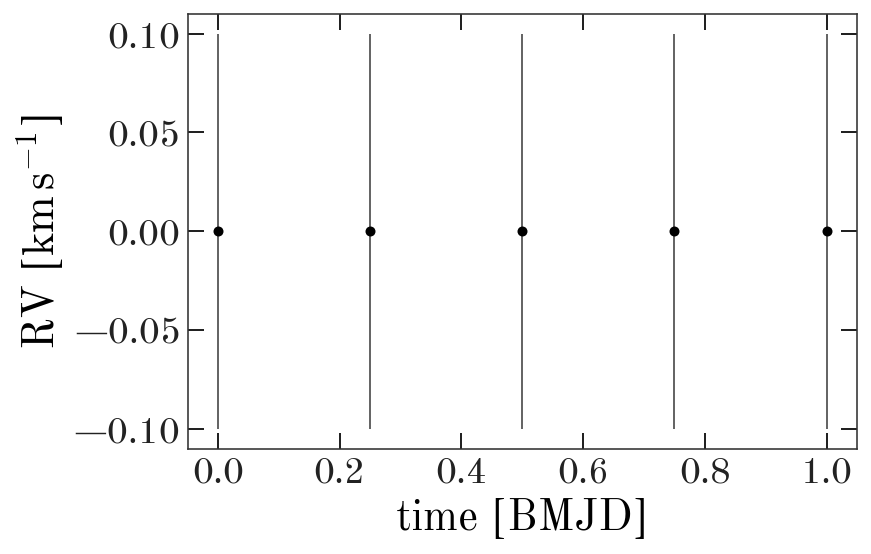

In [230]:
_ = data.plot()

In [231]:
M = np.stack((np.ones((N, nsamples)),
              np.cos(2*np.pi*t[:, None] / P_samples[None] - M0_samples[None]))).T

In [232]:
def get_aA_bB(M, y, C, mu, V):
    Cinv = np.linalg.inv(C)
    Vinv = np.linalg.inv(V)
    
    B = C + M @ V @ M.T
    b = M.dot(mu)
    
    Ainv = Vinv + M.T @ Cinv @ M
    A = np.linalg.inv(Ainv)
    a = A.dot(Vinv @ mu + M.T @ Cinv @ y)

    return a, A, b, B

In [233]:
lls = np.zeros(nsamples)
linear_samples = np.zeros((nsamples, M.shape[-1]))
for i in range(nsamples):
    # varK = (P_samples[i] / 1.)**(-2/3) * 45**2
    # VV = np.diag([1e3**2, varK])
    VV = V
    a, A, b, B = get_aA_bB(M[i], y, C, mu_th, VV)
    lls[i] = multivariate_normal.logpdf(y, mean=b, cov=B)
    linear_samples[i] = np.random.multivariate_normal(a, A)

In [234]:
samples = prior_samples.copy()
samples['v0'] = linear_samples[:, 0] * data.rv.unit
samples['K'] = linear_samples[:, 1] * data.rv.unit

samples['M0'][samples['K'] < 0] += np.pi*u.rad
samples['K'][samples['K'] < 0] = np.abs(samples['K'][samples['K'] < 0])
samples.t0 = data._t0_bmjd

In [235]:
uu = np.random.uniform(size=nsamples)
good_samples_mask = uu < np.exp(lls - lls.max())
good_samples_mask.sum()

5303

(-1, 1)

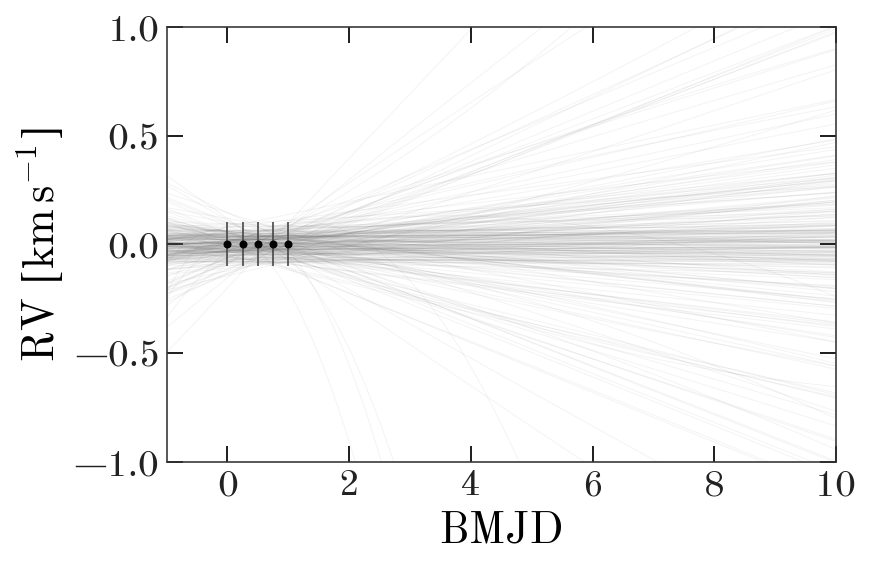

In [236]:
_ = plot_rv_curves(samples[good_samples_mask][:256],
                   data=data,
                   t_grid=np.linspace(-1, 10, 1024))
plt.ylim(-1, 1)

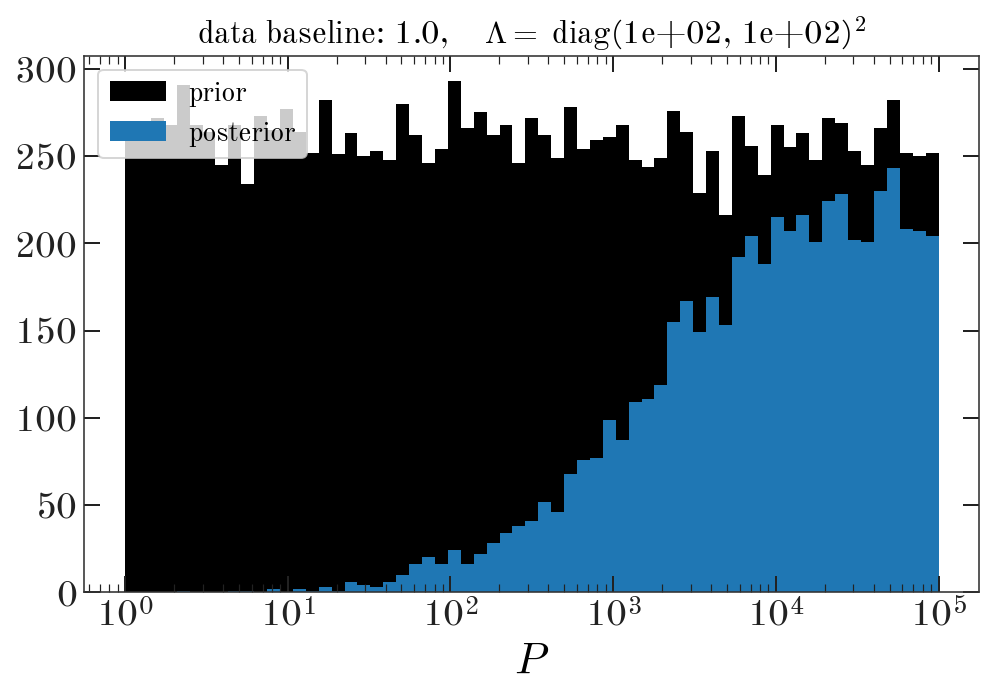

In [237]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
_, bins, *_ = ax.hist(prior_samples['P'].value, 
                      bins=np.geomspace(P_lim[0], P_lim[1], 64),
                      label='prior')
ax.hist(samples['P'].value[good_samples_mask], bins=bins, label='posterior')
ax.set_xscale('log')

baseline = np.ptp(data._t_bmjd)
ax.set_title(r'data baseline: {:.1f},    $\Lambda =$ diag({:.0e}, {:.0e})$^2$'
             .format(baseline, *np.sqrt(Vdiag)), 
             fontsize=16)
ax.set_xlabel('$P$')
ax.legend(loc='upper left', fontsize=14)

fig.tight_layout()
fig.savefig('baseline{:.1f}_V{}.png'
            .format(baseline, '_'.join(['{:.0e}'.format(x) for x in np.sqrt(Vdiag)])),
            dpi=250)

---

In [52]:
from thejoker.sampler.likelihood import marginal_ln_likelihood, design_matrix, cy_rv_from_elements
import h5py
from schwimmbad import SerialPool

In [53]:
with h5py.File('/Users/apricewhelan/Downloads/test_joker.hdf5', 'r') as f:
    nonlinear_ps = f['samples'][:]

In [57]:
joker_lls = np.array([marginal_ln_likelihood(nonlinear_ps[i], data, joker.params) 
                      for i in range(len(nonlinear_ps))])

In [58]:
joker_good_samples_mask = uu < np.exp(joker_lls - joker_lls.max())
joker_samples = prior_samples[joker_good_samples_mask]
len(joker_samples)

9273

In [59]:
# lnlike = compute_likelihoods(nsamples, '/Users/apricewhelan/Downloads/test_joker.hdf5', 0, data,
#                              pars, SerialPool())

In [60]:
# joker_samples, lnprior, lnlike = joker.rejection_sample(
#     data, n_prior_samples=nsamples,
#     return_logprobs=True,
#     prior_cache_file='/Users/apricewhelan/Downloads/test_joker.hdf5')

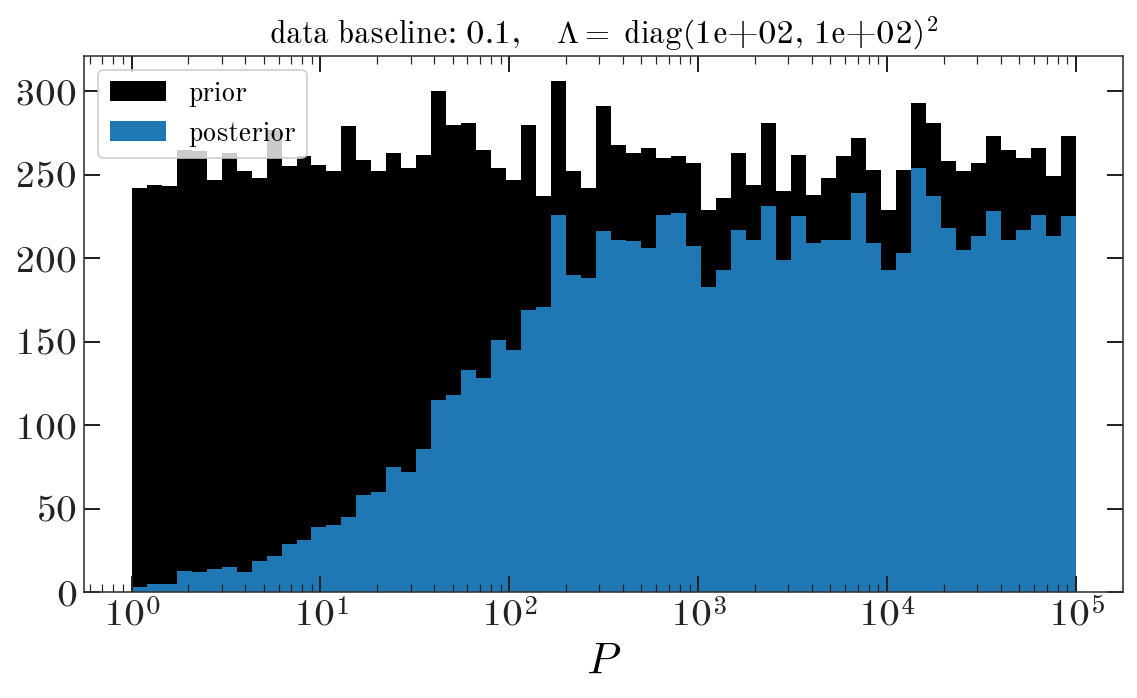

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
_, bins, *_ = ax.hist(prior_samples['P'].value, 
                      bins=np.geomspace(P_lim[0], P_lim[1], 64),
                      label='prior')
ax.hist(joker_samples['P'].value, bins=bins, label='posterior')
ax.set_xscale('log')

baseline = np.ptp(data._t_bmjd)
ax.set_title(r'data baseline: {:.1f},    $\Lambda =$ diag({:.0e}, {:.0e})$^2$'
             .format(baseline, *np.sqrt(Vdiag)), 
             fontsize=16)
ax.set_xlabel('$P$')
ax.legend(loc='upper left', fontsize=14)

fig.tight_layout()
fig.savefig('baseline{:.1f}_V{}.png'
            .format(baseline, '_'.join(['{:.0e}'.format(x) for x in np.sqrt(Vdiag)])),
            dpi=250)

---

In [64]:
phase_samples = np.arctan2(samples[:, 2], samples[:, 1])
amp_samples = np.sqrt(samples[:, 1]**2 + samples[:, 2]**2)

In [65]:
from corner import corner

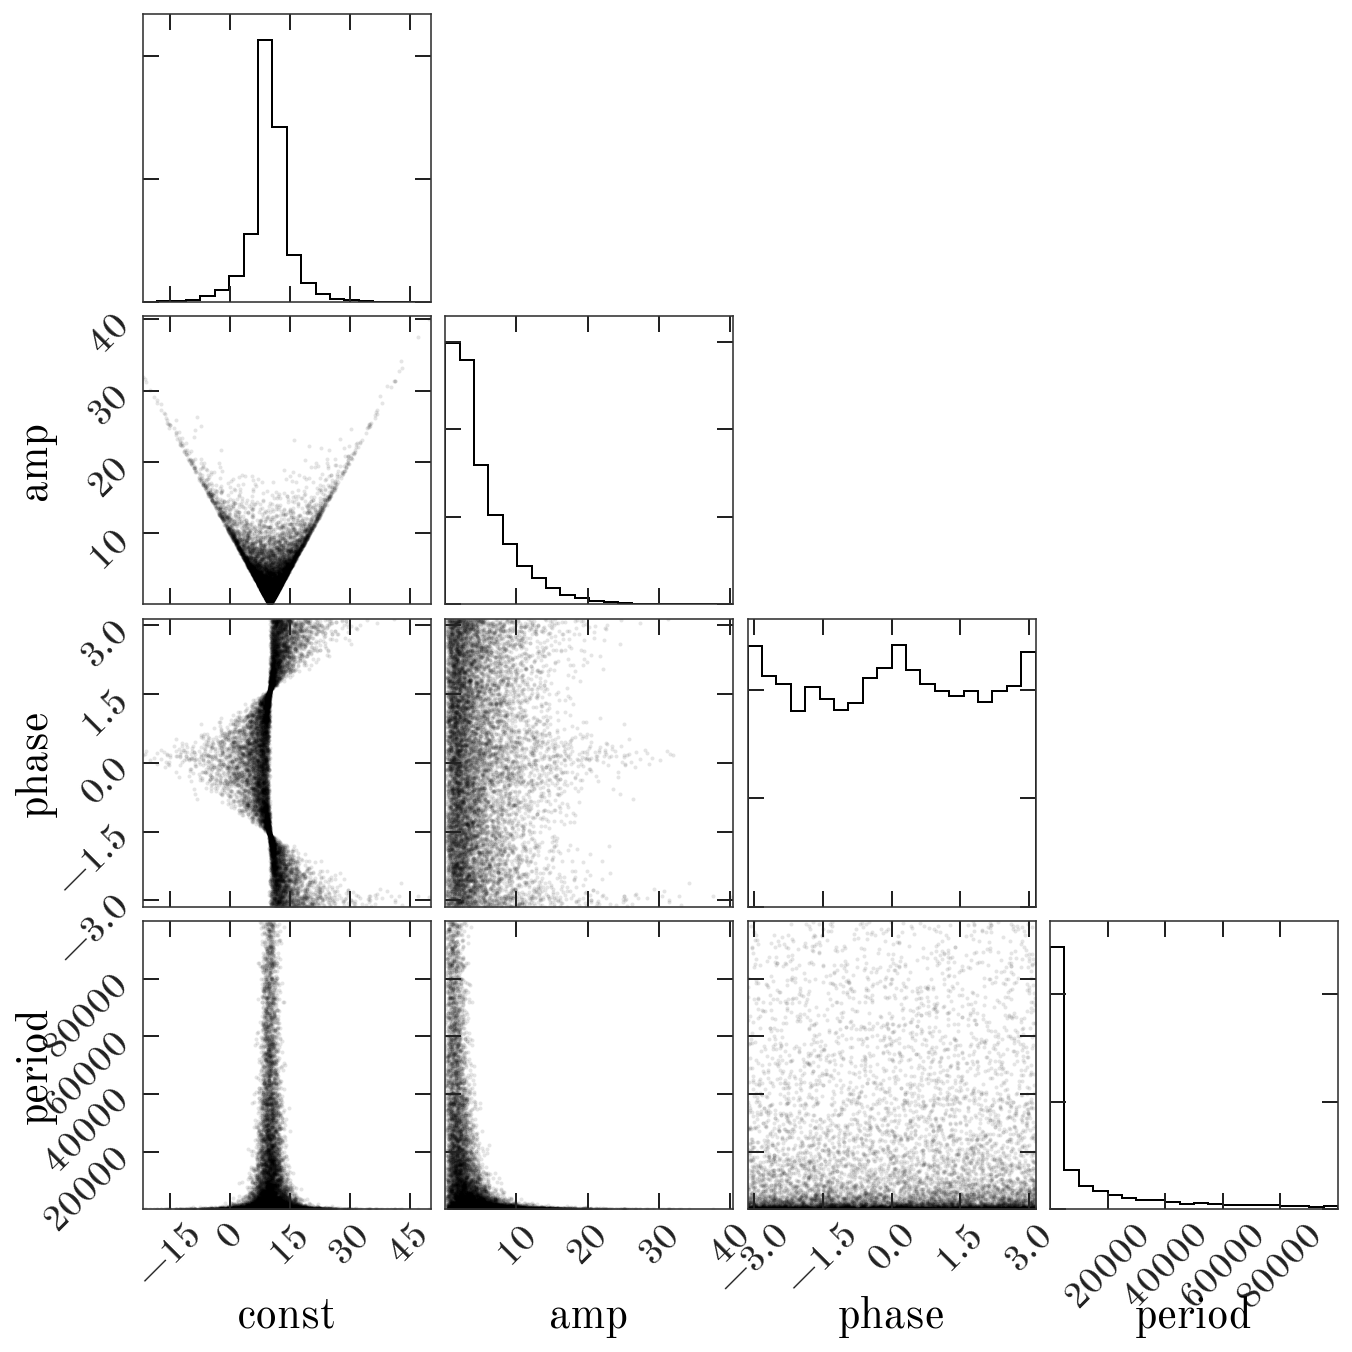

In [66]:
flat = np.stack((samples[:, 0], amp_samples, phase_samples, P_samples)).T[good_samples_mask]
_ = corner(flat, plot_contours=False, plot_density=False, labels=['const', 'amp', 'phase', 'period'])

(8.0, 12.0)

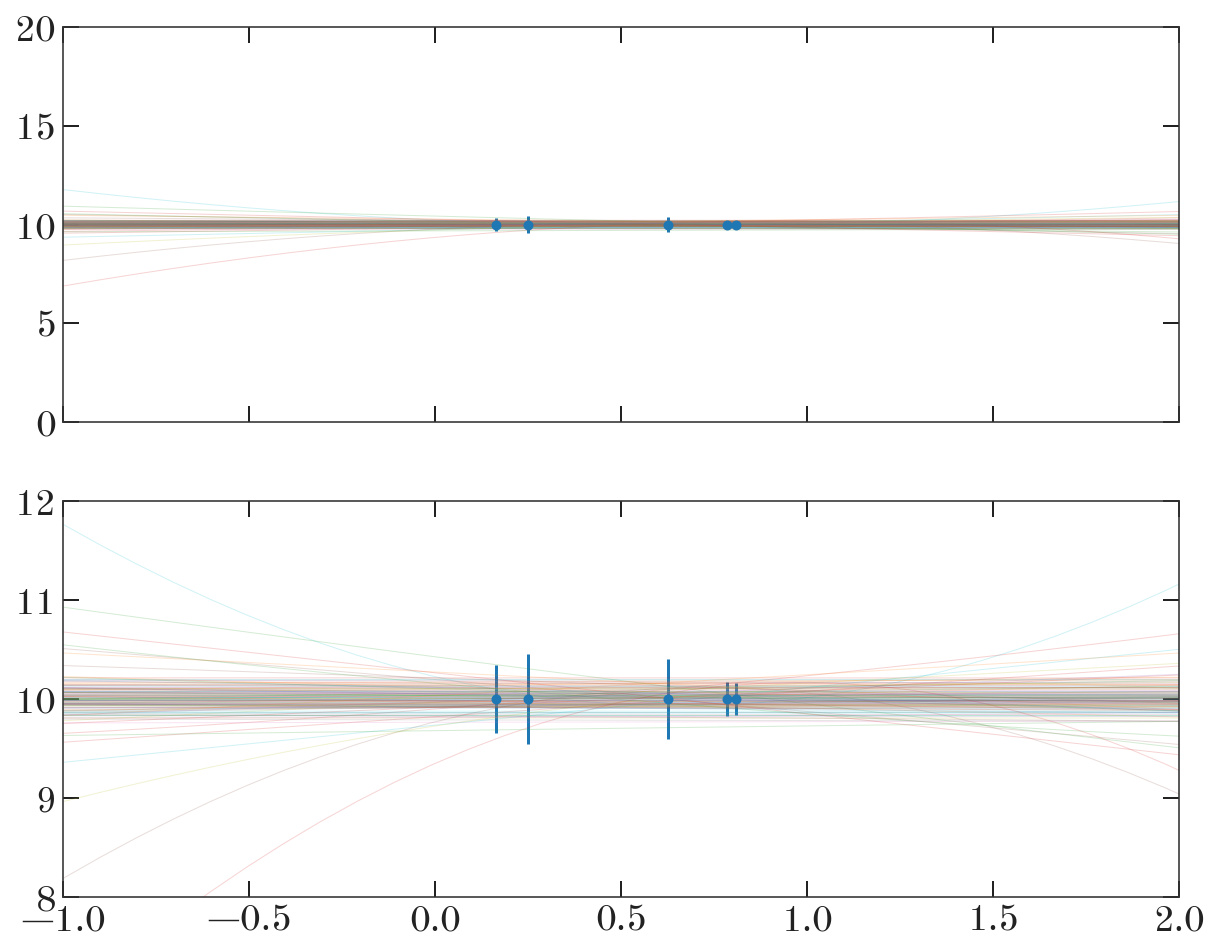

In [67]:
model_t = np.linspace(-1, 100., 1024)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for ax in axes:
    ax.errorbar(t, y, sig_y, marker='o', ls='none')

    for j in np.where(good_samples_mask)[0][:128]:
        ax.plot(model_t, 
                (samples[j][0] + samples[j][1] * np.cos(2*np.pi*model_t / P_samples[j]) + 
                 samples[j][2] * np.sin(2*np.pi*model_t / P_samples[j])),
                marker='', lw=0.5, alpha=0.2)

axes[0].set_ylim(0, 20)
axes[1].set_xlim(-1, 2)
axes[1].set_ylim(np.mean(y) - 2, np.mean(y) + 2)